In [247]:
import pandas as pd
from sklearn.impute import SimpleImputer
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import balanced_accuracy_score, log_loss
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import log_loss


In [198]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

In [199]:
# Check for missing values
missing_values_train = train_data.isnull().sum()
missing_values_test = test_data.isnull().sum()

# Print the columns with missing values
print(f"Missing Values in Training Data",missing_values_train[missing_values_train > 0])
print(f"Missing Values in Training Data",missing_values_test[missing_values_test > 0])

Missing Values in Training Data BQ    60
CB     2
CC     3
DU     1
EL    60
FC     1
FL     1
FS     2
GL     1
dtype: int64
Missing Values in Training Data Series([], dtype: int64)


In [196]:
#Use mean imputer for missing values 

imputer = SimpleImputer(strategy='mean')
imputed_train = imputer.fit_transform(train_data.drop(columns = ['EJ','Id','Class']))
train_data[train_data.drop(columns = ['EJ','Id','Class']).columns] = imputed_train

In [200]:
#Create One Hot Encoding for Categorical Feature EJ
encoded_ej_train = pd.get_dummies(train_data['EJ'])
encoded_ej_test = pd.get_dummies(test_data['EJ'])

#Create X_train using imputed and encoded data
X_train = train_data.drop(columns=['EJ','Class','Id'])
X_train = pd.concat([X_train, encoded_ej_train],axis=1)

#Create X_train using imputed and encoded data
X_test = test_data.drop(columns=['EJ','Id'])
X_test = pd.concat([X_test, encoded_ej_test],axis=1)



<AxesSubplot: >

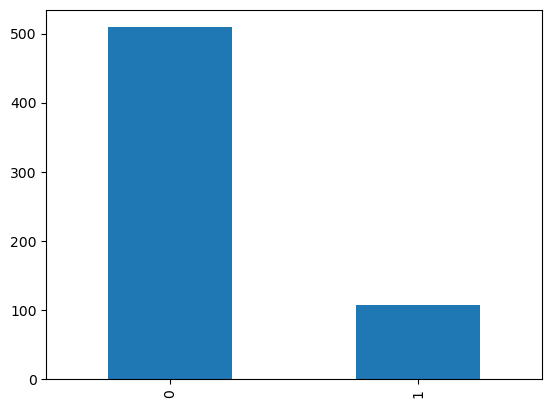

In [88]:
##Check for class imbalance
y_train = train_data.Class
y_train.value_counts().plot.bar()

In [89]:
#Use random undersampler to undersample class 0

undersampler = RandomUnderSampler(sampling_strategy=1) #Numerical value
X_train_balanced, y_train_balanced = undersampler.fit_resample(X_train,y_train)


<AxesSubplot: >

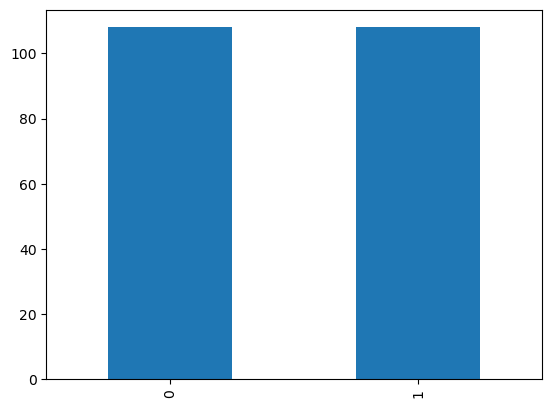

In [90]:
y_train_balanced.value_counts().plot.bar()


In [150]:
scalar  = StandardScaler()
X_train_scaled = pd.DataFrame(scalar.fit_transform(X_train_balanced),columns=X_train.columns)

In [151]:
#Create correlation matrix 
correlation = pd.concat([X_train_scaled,y_train_balanced],axis = 1).corr()

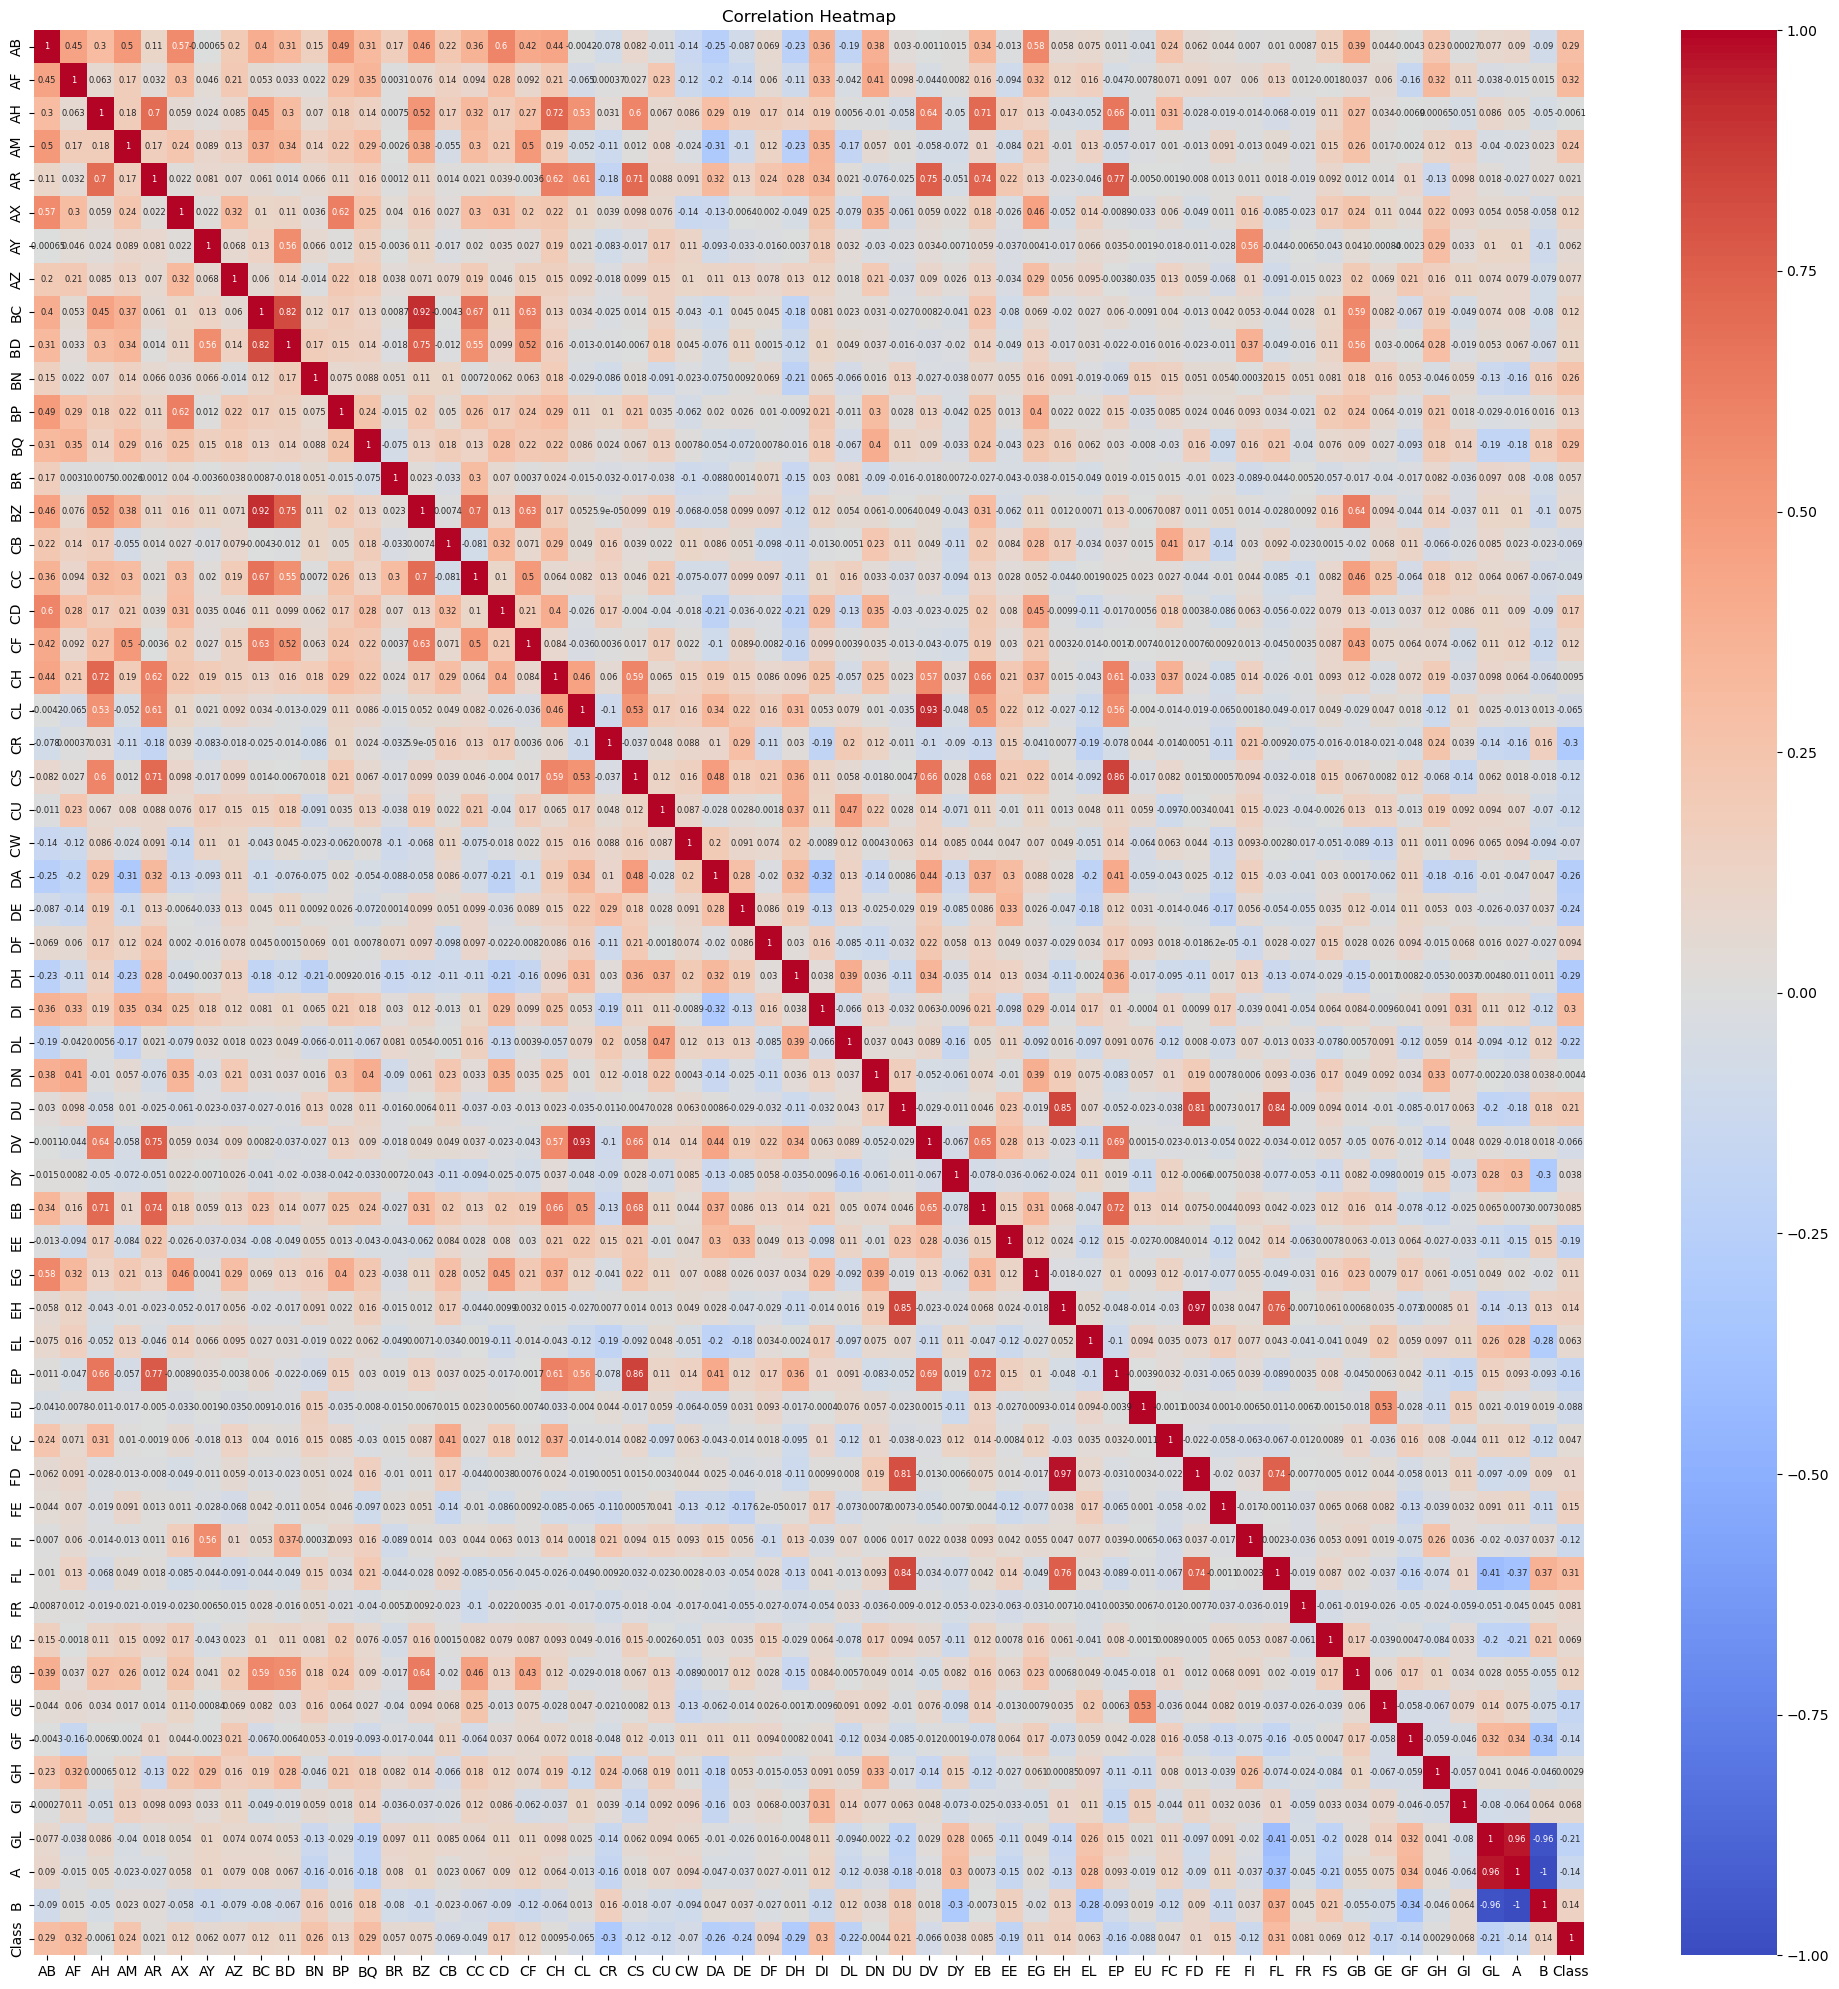

In [152]:
##Plot Correlation Matrix Heatmap
plt.figure(figsize=(25, 25))
sns.heatmap(correlation, cmap="coolwarm" ,annot= True,annot_kws={"fontsize": 6})
# Display the heatmap
plt.title('Correlation Heatmap')
plt.show()

In [176]:
## From the heatmap above we can see a couple of features are very highly correlated
## We can also see wich features are least correlated with the class target
drop_features = ['GL','FD ','DV', 'BZ','EP','EH']

correlation2 = pd.concat([X_train_scaled.drop(columns= drop_features),y_train_balanced],axis = 1).corr()

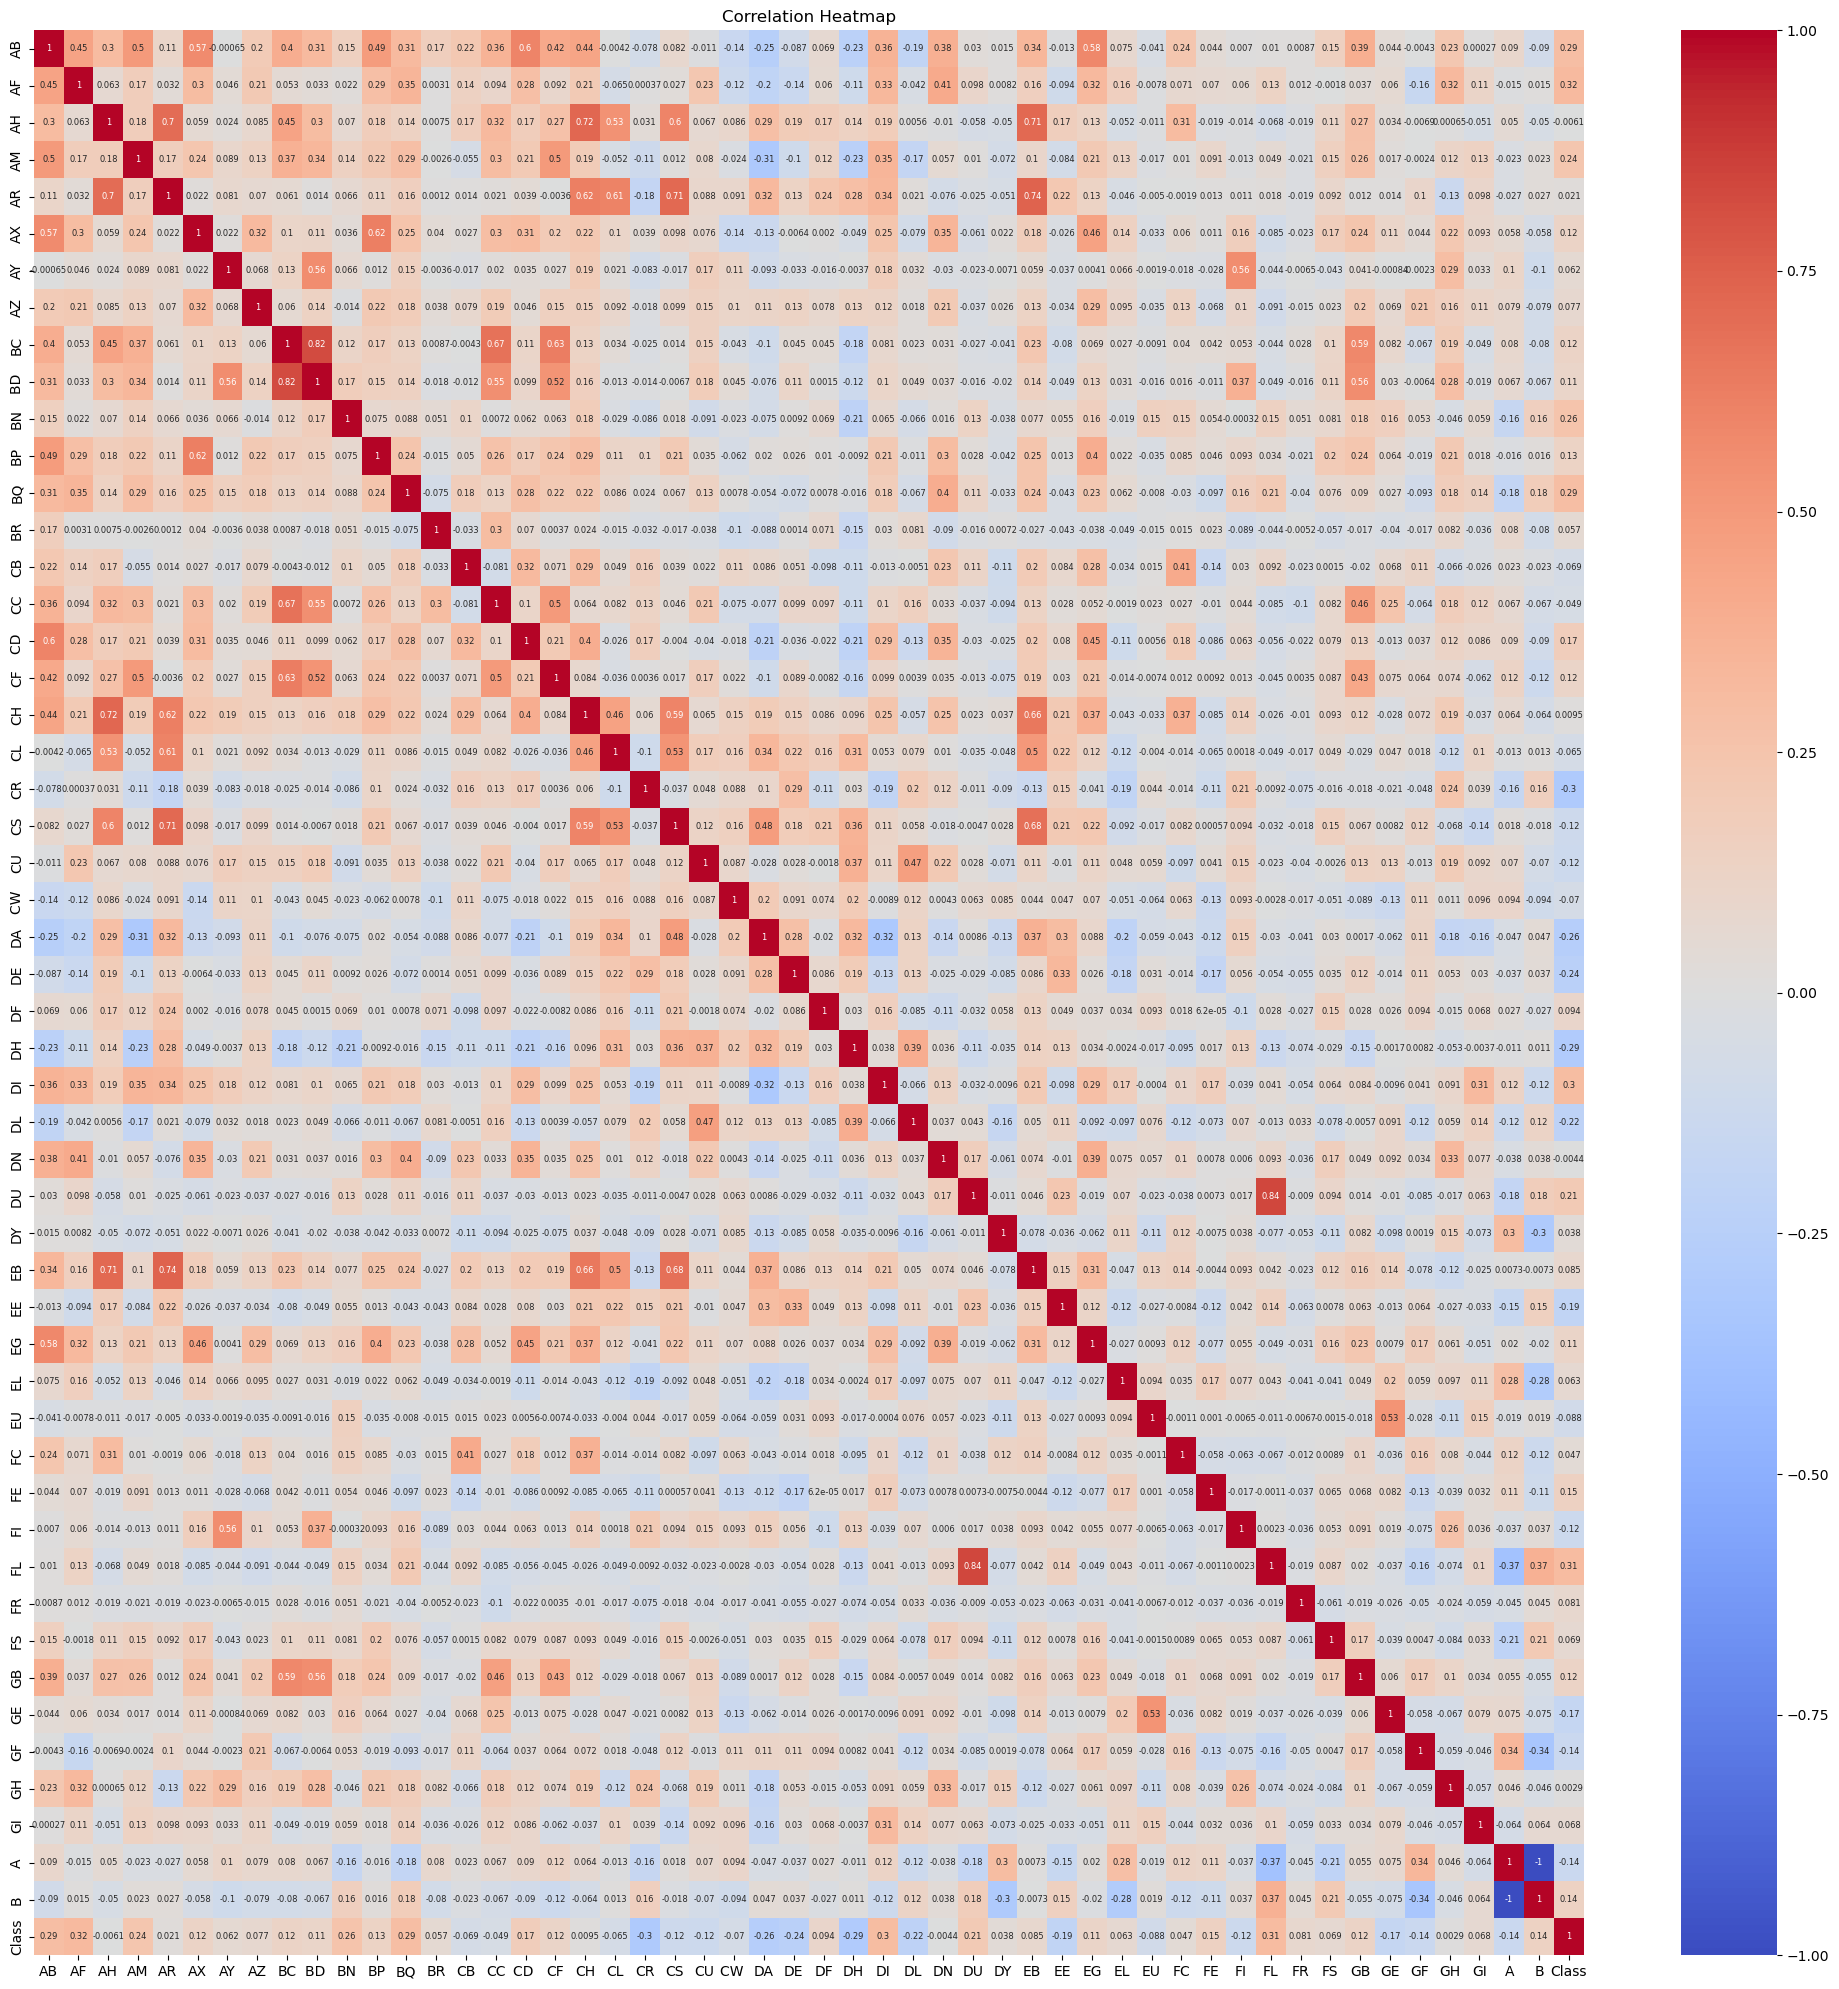

In [177]:
plt.figure(figsize=(25, 25))
sns.heatmap(correlation2, cmap="coolwarm" ,annot= True,annot_kws={"fontsize": 6})
# Display the heatmap
plt.title('Correlation Heatmap')
plt.show()

In [214]:
X_train_data, X_test_data, y_train_data, y_test_data = train_test_split(X_train_scaled.drop(columns = drop_features),y_train_balanced,test_size=0.20, random_state=42)

In [242]:
y_train_data.value_counts()

0    91
1    81
Name: Class, dtype: int64

In [243]:
class_weights

{0: 1, 1: 2.123456790123457}

In [253]:
##Calculate calss wights
class_weights = {0: 1, 1: len(y_train_data) / sum(y_train_data)}
##Train random forest classifer with class weights
forest_clf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42,class_weight=class_weights)
forest_clf.fit(X_train_data, y_train_data)
## Use classifer to predict on X_test_data
y_pred = forest_clf.predict(X_test_data)
y_pred_prob = forest_clf.predict_proba(X_test_data)


In [255]:
balanced_acc = balanced_accuracy_score(y_test_data, y_pred)
log_loss_balanced = log_loss(y_test_data, y_pred)
print(f"Balanced Accuracy:",balanced_acc)
print(f"Balanced Log-Loss:",log_loss_balanced)


Balanced Accuracy: 0.8965141612200436
Balanced Log-Loss: 3.9248791266359917


In [248]:
print(classification_report(y_test_data, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.94      0.86        17
           1       0.96      0.85      0.90        27

    accuracy                           0.89        44
   macro avg       0.88      0.90      0.88        44
weighted avg       0.90      0.89      0.89        44



In [249]:
param_grid = {
    'bootstrap': [True, False],
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 15],
    'max_features': ['auto', 'sqrt'],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10],
    'n_estimators': [200, 400, 600]

    # Add other parameters you want to optimize
}
grid_search = GridSearchCV(estimator=forest_clf, param_grid=param_grid, scoring='neg_log_loss', cv=5)


In [250]:
grid_search.fit(X_train_data, y_train_data)


GridSearchCV(cv=5,
             estimator=RandomForestClassifier(class_weight={0: 1,
                                                            1: 2.123456790123457},
                                              max_depth=10, random_state=42),
             param_grid={'bootstrap': [True, False], 'max_depth': [5, 10, 15],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [200, 400, 600]},
             scoring='neg_log_loss')

In [267]:
best_forest_clf = grid_search.best_estimator_

In [268]:
y_pred = best_forest_clf.predict(X_test_data)
log_loss_score = log_loss(y_test_data, y_pred)
print(f"Log-Loss Score: ", log_loss_score)

Log-Loss Score:  0.7849721907934254


In [269]:
print(classification_report(y_test_data, y_pred))

              precision    recall  f1-score   support

           0       0.94      1.00      0.97        17
           1       1.00      0.96      0.98        27

    accuracy                           0.98        44
   macro avg       0.97      0.98      0.98        44
weighted avg       0.98      0.98      0.98        44

